In [33]:
import Pkg
packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
    "Accessors",
]

Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [34]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 
using Accessors

In [35]:
# 1. 2-DOF Oscillator (Duffing + Cubic Damping)
function two_mass_nonlinear!(du, u, p, t)
    # Unpack state
    x1, v1, x2, v2 = u[1], u[2], u[3], u[4]
    
    # Element 1 
    # Linear parts
    fs1_lin = p.k1 * x1
    fd1_lin = p.c1 * v1
    # Nonlinear parts (Cubic Stiffness + Cubic Damping)
    fs1_non = p.alpha1 * (x1^3)
    fd1_non = p.gamma1 * (v1^3)
    
    # Total forces from Element 1 
    F1_total = -(fs1_lin + fs1_non + fd1_lin + fd1_non)
    
    # Element 2 (Mass 1 to Mass 2) 
    # Relative state
    dx = x2 - x1
    dv = v2 - v1
    
    # Linear parts
    fs2_lin = p.k2 * dx
    fd2_lin = p.c2 * dv
    # Nonlinear parts 
    fs2_non = p.alpha2 * (dx^3)
    fd2_non = p.gamma2 * (dv^3)
    
    # Total forces from Element 2
    F2_total = fs2_lin + fs2_non + fd2_lin + fd2_non
    
    # Driving Force 
    F_drive = p.F * cos(p.omega * t)

    # Equations of Motion 
    du[1] = v1
    du[2] = (F1_total + F2_total) / p.m1
    
    du[3] = v2
    du[4] = (-F2_total + F_drive) / p.m2
end

# 2. Parameters
par_2dof = (
    m1 = 1.0, m2 = 1.0, 
    k1 = 1.0, k2 = 1.0, 
    c1 = 0.05, c2 = 0.01, 
    alpha1 = 0, alpha2 = 0,  
    gamma1 = 0, gamma2 = 0, 
    F = 0.5, omega = 0.1
)

(m1 = 1.0, m2 = 1.0, k1 = 1.0, k2 = 1.0, c1 = 0.05, c2 = 0.01, alpha1 = 0, alpha2 = 0, gamma1 = 0, gamma2 = 0, F = 0.5, omega = 0.1)

In [36]:
# 3. Poincare Map
function poincare_map_2dof(u, p)
    omega = (p isa Real) ? p : p.omega
    T = 2π / omega
    
    prob = ODEProblem(two_mass_nonlinear!, u, (0.0, T), p)
    sol = solve(prob, Rodas4(), reltol=1e-9, abstol=1e-9, save_everystep=false)
    
    return sol[end] - u
end

poincare_map_2dof (generic function with 1 method)

In [37]:
# 4. Problem Definition
u0 = [0.0, 0.0, 0.0, 0.0]

prob = BifurcationProblem(poincare_map_2dof, u0, par_2dof, (@optic _.omega);
    record_from_solution = (x, p; k...) -> begin
        current_omega = (p isa Real) ? p : p.omega
        
        p_full = (
            m1=par_2dof.m1, m2=par_2dof.m2, 
            k1=par_2dof.k1, k2=par_2dof.k2, 
            c1=par_2dof.c1, c2=par_2dof.c2,
            alpha1=par_2dof.alpha1, alpha2=par_2dof.alpha2, 
            gamma1=par_2dof.gamma1, gamma2=par_2dof.gamma2, 
            F=par_2dof.F, 
            omega=Float64(current_omega)
        )
        
        T = 2π / p_full.omega
        prob_rec = ODEProblem(two_mass_nonlinear!, x, (0.0, T), p_full)
        sol_rec = solve(prob_rec, Rodas4(), reltol=1e-8, abstol=1e-8)
        
        # Plotting Amplitude of Mass 2
        return maximum(abs.(sol_rec[3, :]))
    end
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace: false
├─ Dimension: 4
├─ Symmetric: false
└─ Parameter: omega

In [38]:
# 5. Continuation Options
opts = ContinuationPar(
    p_min = 0.01, 
    p_max = 2.5,      
    ds = 0.01,
    dsmax = 0.05,
    max_steps = 2000, 
    detect_bifurcation = 0,
    newton_options = NewtonPar(tol = 1e-8, max_iterations = 20) 
)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.05
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 0.01
  p_max: Float64 2.5
  max_steps: Int64 2000
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 0
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [39]:
# 6. Run Continuation
branch = continuation(prob, PALC(), opts)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 936
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.1, ends at 2.5
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +2.50000000,                                                                     step = 935


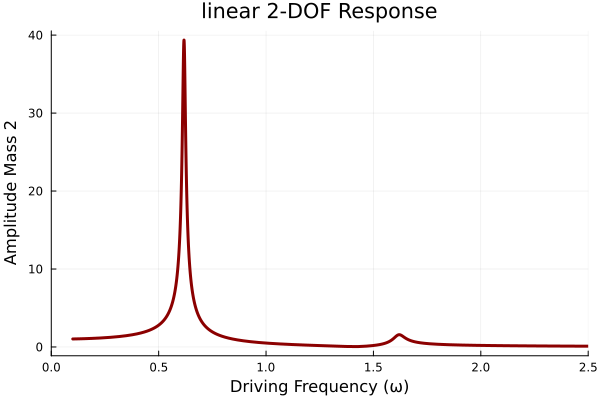

In [40]:
# 7. Plotting
plot(branch, 
    title = "linear 2-DOF Response",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Amplitude Mass 2",
    lw = 3, color = :darkred, legend = false,
    xlims = (0, 2.5)
)